In [134]:
import torch
import torch.nn as nn
import os
import pandas as pd
from skimage import io, transform
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms, utils

import matplotlib.pyplot as plt
%matplotlib inline

## Image loading and processing

In [136]:
class StanfordDogsDataset():
    '''Stanford Dogs Dataset'''
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)  
        
        if self.transform:
            image = self.transform(image)
            
        return {'image': image, 'label': self.labels.iloc[idx, 1]}

# preprocessing pipeline, heavy augmentation
data_transform = transforms.Compose([
        transforms.Scale(size=224),
        transforms.RandomSizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        transforms.ToTensor()])
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])])

dataset = StanfordDogsDataset(csv_file='../data/labels.csv',
                              root_dir='../data/train/',
                              transform=data_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

## Visualization

torch.Size([4, 3, 224, 224]) ['tibetan_terrier', 'bloodhound', 'staffordshire_bullterrier', 'gordon_setter']


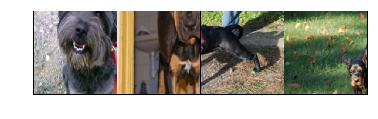

In [138]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images, labels = sample_batched['image'], sample_batched['label']
    batch_size = len(images)
    im_size = images.size(2)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    

for batch in dataloader:
    print(batch['image'].size(), batch['label'])
    plt.figure()
    show_landmarks_batch(batch)
    plt.axis('off')
    plt.show()
    break

## Performance

In [131]:
import time

def timeit(fn):
    def timed(*args, **kw):
        ts = time.time()
        result = fn(*args, **kw)
        te = time.time()
        print('Batch size: {} - {}s/batch - {}s/img'.format(result, 
                                                            format(te-ts, '.4f'), 
                                                            format((te-ts) / result, '.4f')))
        return result
    return timed

@timeit
def time_batch():
    for sample_batched in dataloader:
        x = sample_batched['image']
        y = sample_batched['label']
        return dataloader.batch_size
            
for batch_size in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    dataloader.batch_size = batch_size
    time_batch()

Batch size: 2 - 0.0261s/batch - 0.0130s/img
Batch size: 4 - 0.0331s/batch - 0.0083s/img
Batch size: 8 - 0.0582s/batch - 0.0073s/img
Batch size: 16 - 0.1472s/batch - 0.0092s/img
Batch size: 32 - 0.3199s/batch - 0.0100s/img
Batch size: 64 - 0.5281s/batch - 0.0083s/img
Batch size: 128 - 1.1845s/batch - 0.0093s/img
Batch size: 256 - 2.3136s/batch - 0.0090s/img
Batch size: 512 - 4.5986s/batch - 0.0090s/img
Batch size: 1024 - 9.9808s/batch - 0.0097s/img
